# MOFA+ and AnnData interoperability

This notebooks contains the demonstration of how to train a MOFA+ model on an AnnData object or a loom file connection.

In [70]:
import scanpy as sc
import mofapy2
from mofapy2.run.entry_point import mofa

## AnnData / scanpy

### Preparing data

In [136]:
#!wget -P data/pbmc3k/ 'https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz'
#!tar -C data/pbmc3k/ -zxvf 'data/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz'
adata = sc.read_10x_mtx("../data/filtered_feature_bc_matrix/")

Do the preprocessing following the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html):

In [137]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['percent_mito'] < 0.2, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, making a copy.


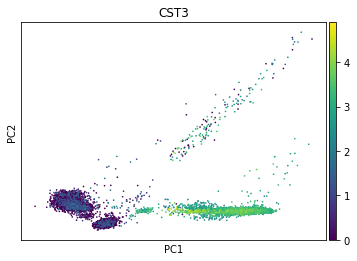

In [145]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca(adata, color='CST3')

/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


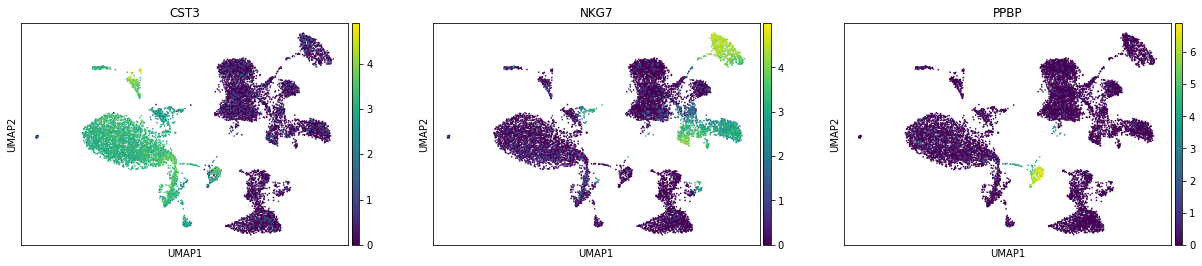

In [146]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

### Training a MOFA+ model

Once we've got an AnnData object with pre-processed scRNA-seq data, we can just run MOFA+ on the data using a convenient `mofa()` wrapper that creates the model, sets model & training options, runs the training, and saves the MOFA+ embeddings to the AnnData object. It preserves the flexibility of the MOFA+ framework as well: there are many parameters one can adjust with `mofa()` function arguments.

In [ ]:
# Use a verbose and non-quiet version if you want to monitor the training:
# mofa(adata, convergence_mode="fast", quiet=False, verbose=True)
mofa(adata, convergence_mode="fast")

#### Implementation details

Under the hood, `mofa()` encompasses a few sequential calls to create the model, set data, model, and training options ("prepare" the model), and then run the training and save the model to an HDF5 file and also add factor values and factor weights to the AnnData object.

Most importantly, it uses `set_data_from_anndata()` function similar to the `set_data_from_loom()` described below.

### Working with a trained MOFA+ model

By default, factor values are saved in `adata.obsm["X_mofa"]` and their loadings are saved in `adata.varm["LFs"]`.

In [148]:
print(f"Factors: {adata.obsm['X_mofa'].shape} numpy ndarray")
print(f"Loadings: {adata.varm['LFs'].shape} numpy ndarray")

Factors: (10990, 10) numpy ndarray
Loadings: (2076, 10) numpy ndarray


We can add the factor values of interest to the observations data frame of the AnnData object to take advantage of scanpy built-in plotting functionality, e.g.:

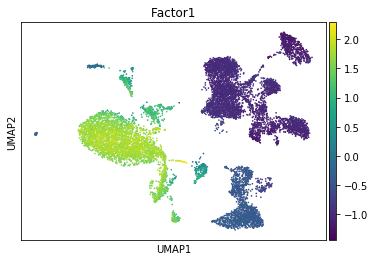

In [149]:
adata.obs["Factor1"] = adata.obsm["X_mofa"][:,0]
sc.pl.umap(adata, color="Factor1")

While currently we provide [model investigation and plotting function in R](https://github.com/bioFAM/MOFA2/tree/master/MOFA2/vignettes), one can for instance use [Seaborn](https://seaborn.pydata.org/) to quickly plot the factor values in Python:

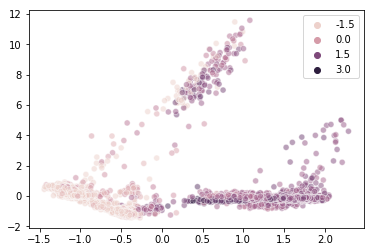

In [150]:
import seaborn as sns
sns.scatterplot(x=adata.obsm["X_mofa"][:,0], 
                y=adata.obsm["X_mofa"][:,1],
                hue=np.array(adata[:,"CST3"].X),
                alpha=0.5)

## loom / loompy

You could also train a model from a loom file. 

In [16]:
# Download a test file from the loompy repository
#!wget -P data/pbmc10k/ "https://github.com/linnarsson-lab/loompy/raw/master/test.loom"

In [18]:
from mofapy2.run.entry_point import entry_point as mofa_model
import loompy
loom = loompy.connect("data/pbmc10k/test.loom")
loom

,Cell,0,1,2,3,4,5,6,7,8,9,...
Gene,,,,,,,,,,,,...
A,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
B,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
C,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
D,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
E,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
F,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
G,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
H,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
I,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


### Prepare a MOFA+ model

First create a class instance for the model:

In [21]:
model = mofa_model()



           |￣￣￣￣￣￣￣|
           |             |
           |    MOFA+    |
           |             |
           | ＿＿＿＿＿＿_|
           (\__/) ||
           (•ㅅ•)  ||
           / 　 づ
        


Then set the necessary data options, model options, and training options. For a mode detailed overview of the optional arguments please see the [template_run.py script](https://github.com/bioFAM/MOFA2/blob/master/template_run.py).

In [26]:
llh = ["gaussian"]
model.set_data_options(likelihoods=llh)

# This imports the data from the loom file.
# Use the `groups_label` argument to provide a name of 
# the loom.ca attribute to be used to define groups of cells.
model.set_data_from_loom(loom, cell_id="Cell")

model.set_model_options(factors=10, likelihoods=llh)
model.set_train_options()

model.build()


Loaded view='rna' group='group1' with N=200 samples and D=20 features...




### 

In [ ]:

model.run()
model.save("data/mofaplus_model_from_loom.hdf")